In [1]:
import pandas as pd
import numpy as np
import pymc as pm

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Speed
Our response will be predicted get off time
    - Need to decide how we want to do this
    - Option 1 is amount of time to get to a certain distance (Say 1.5 yards)
    - Option 2 would be predicted yards given a cetain amount of time
For predictors:
    - Height/weight of the tackle
    - Quarter
    - Whether it's an obvious passing situation
    - Left vs right tackle?

## Power
Our response here is some variation of percentage of the distance to the QB given up once engaged with the defensive end
For predictors:
    - Height/weight of both the tackle and the end
    - Obvious passing situation
    - Time to throw for the QB
    - Quarter

In [24]:
model_data = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/clustered.csv')

In [25]:
model_data.columns

Index(['uniqueplayId', 'QB_Flip', 'rushType', 'Power_prob', 'Speed_prob',
       'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'playDirection', 'event', 'ball_snap_frame', 'end_frame',
       'play_length_frames', 'Right_end', 'Left_end', 'QB_nflId',
       'QB_jerseyNumber', 'QB_team', 'QB_x', 'QB_y', 'QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp',
       'QB_pff_nflIdBlockedPlayer', 'QB_pff_blockType', 'QB_new_x', 'QB_new_y',
       'ball_nflId', 'ball_jerseyNumber', 'ball_team', 'ball_x', 'ball_y',
       'ball_s', 'ball_a', 'ball_dis', 'ball_o', 'ball_dir', 'ball_pff_role',
       'ball_pff_positionLinedUp', 'ball_pff_nflIdBlockedPlayer',
       'ball_pff_blockType', 'ball_new_x', 'ball_new_y', 'ball_Flip',
       'Tackle_nflId', 'Tackle_jerseyNumber', 'Tackle_team', 'Tackle_x',
       'Tackle_y', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLined

In [26]:
model_data2 = model_data[['uniqueplayId','QB_Flip','rushType','Power_prob','Speed_prob',
            'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'event','play_length_frames','QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp','QB_new_x', 'QB_new_y',
            'ball_new_x', 'ball_new_y', 'ball_Flip','ball_snap_frame',
       'Tackle_nflId', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLinedUp',
       'Tackle_pff_nflIdBlockedPlayer', 'Tackle_pff_blockType', 'Tackle_new_x',
       'Tackle_new_y', 'Tackle_Flip', 'End_nflId', 'End_s', 'End_a', 'End_dis', 'End_o',
       'End_dir', 'End_pff_role', 'End_pff_positionLinedUp', 'End_new_x',
       'End_new_y', 'End_Flip', 'tackle_end_dist', 'tackle_end_facing']]

In [27]:
players = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/players.csv')

In [28]:
players = players[['height', 'weight', 'nflId','displayName']]

In [29]:
model_data3 = model_data2.merge(players, left_on = 'Tackle_nflId', right_on = 'nflId', how = 'left')

In [30]:
model_data4 = model_data3.rename(columns = {'height':'tackle_height','weight':'tackle_weight','displayName':'tackle_name'}).drop('nflId', axis = 1)

In [31]:
model_data5 = model_data4.merge(players, left_on = 'End_nflId', right_on = 'nflId', how = 'left')

In [32]:
model_data6 = model_data5.rename(columns = {'height':'end_height','weight':'end_weight','displayName':'end_name'}).drop('nflId', axis = 1)

In [33]:
plays = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [34]:
plays['obvious_pass'] = ((plays['down'] == 2) & (plays['yardsToGo'] > 10)) | ((plays['down'] == 3) & (plays['yardsToGo'] > 4)) | ((plays['down'] == 4) & (plays['yardsToGo'] > 2))

In [35]:
plays['obvious_pass'] = plays['obvious_pass'].astype(int)

In [36]:
plays = plays[['gameId','playId','quarter','obvious_pass']]

In [37]:
plays

,gameId,playId,quarter,obvious_pass
0,2021090900,97,1,0
1,2021090900,137,1,0
2,2021090900,187,1,0
3,2021090900,282,1,0
4,2021090900,349,1,1
...,...,...,...,...
8553,2021110100,4310,4,1
8554,2021110100,4363,4,0
8555,2021110100,4392,4,0
8556,2021110100,4411,4,1


In [38]:
model_data7 = model_data6.merge(plays, on = ['gameId','playId'], how = 'left')

In [39]:
model_data7['tackle_end_engaged'] = (model_data7['tackle_end_facing'] <= 40) & (model_data7['tackle_end_dist'] <= 1)

In [40]:
model_data7['tackle_end_engaged'] = model_data7['tackle_end_engaged'].astype(int)

In [41]:
model_data7['tackle_end_engaged'].value_counts()

0    217991
1     70416
Name: tackle_end_engaged, dtype: int64

In [42]:
def dist(x_1, y_1, x_2, y_2):
    return np.sqrt(np.sum([(x_1-x_2)**2, (y_1-y_2)**2], axis=0))

In [43]:
model_data7['tackle_qb_dist'] = dist(model_data7['Tackle_new_x'], model_data7['Tackle_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [44]:
model_data7['end_qb_dist'] = dist(model_data7['End_new_x'], model_data7['End_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [45]:
speed = model_data7[model_data7['rushType'] == 'Speed']
speed

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,tackle_weight,tackle_name,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist
0,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,6,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.554492,2.944300
1,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,7,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.610878,3.008920
2,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,8,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.651021,3.091035
3,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,9,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.667987,3.220761
4,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,10,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.714106,3.402029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288331,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,27,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.893107,6.758913
288332,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,28,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.787839,6.807437
288333,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,29,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.674409,6.866513
288334,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,30,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.555052,6.941823


In [46]:
model_data7 = model_data7[(model_data7['tackle_qb_dist'] < model_data7['end_qb_dist']) & (model_data7['rushType'] != 'Speed')]

In [47]:
model_data7['rushType'].value_counts()

Power    178518
Name: rushType, dtype: int64

In [48]:
subset = model_data7[model_data7['tackle_end_engaged'] == 1]

In [49]:
subset2 = subset.groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [50]:
distance_when_engaged = subset2[['uniqueplayId','QB_Flip','tackle_qb_dist']]
distance_when_engaged

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109120163,0.0,3.927467
1,202109120163,1.0,5.853136
2,202109120578,1.0,4.997960
3,202109120676,0.0,4.894865
4,202109120676,1.0,3.900820
...,...,...,...
5547,20211025003660,1.0,5.355978
5548,20211025003904,0.0,3.735305
5549,20211025003904,1.0,4.439279
5550,20211025003926,0.0,4.787118


In [51]:
end_distance = model_data7.groupby(['uniqueplayId','QB_Flip']).last().reset_index()

In [52]:
end_distance = end_distance[['uniqueplayId','QB_Flip','tackle_qb_dist']]
end_distance

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109120163,0.0,2.438237
1,202109120163,1.0,5.594569
2,202109120288,1.0,6.659084
3,202109120578,1.0,2.407094
4,202109120676,0.0,4.827132
...,...,...,...
6218,20211025003660,1.0,3.138057
6219,20211025003904,0.0,2.595149
6220,20211025003904,1.0,4.460717
6221,20211025003926,0.0,8.396076


In [53]:
end_distance = end_distance.rename(columns = {'tackle_qb_dist': 'ending_distance'})

In [54]:
distance = distance_when_engaged.merge(end_distance, on = ['uniqueplayId', 'QB_Flip'], how = 'left')
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance
0,202109120163,0.0,3.927467,2.438237
1,202109120163,1.0,5.853136,5.594569
2,202109120578,1.0,4.997960,2.407094
3,202109120676,0.0,4.894865,4.827132
4,202109120676,1.0,3.900820,1.730665
...,...,...,...,...
5547,20211025003660,1.0,5.355978,3.138057
5548,20211025003904,0.0,3.735305,2.595149
5549,20211025003904,1.0,4.439279,4.460717
5550,20211025003926,0.0,4.787118,8.396076


In [55]:
distance['pct_given_up'] = (distance['tackle_qb_dist'] - distance['ending_distance']) / distance['tackle_qb_dist']
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance,pct_given_up
0,202109120163,0.0,3.927467,2.438237,0.379183
1,202109120163,1.0,5.853136,5.594569,0.044176
2,202109120578,1.0,4.997960,2.407094,0.518385
3,202109120676,0.0,4.894865,4.827132,0.013838
4,202109120676,1.0,3.900820,1.730665,0.556333
...,...,...,...,...,...
5547,20211025003660,1.0,5.355978,3.138057,0.414102
5548,20211025003904,0.0,3.735305,2.595149,0.305238
5549,20211025003904,1.0,4.439279,4.460717,-0.004829
5550,20211025003926,0.0,4.787118,8.396076,-0.753890


In [56]:
distance = distance.rename(columns = {'tackle_qb_dist' : 'starting_distance'})

In [57]:
model_data8 = model_data7.merge(distance, on = ['uniqueplayId','QB_Flip'], how = 'left')
model_data8

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,starting_distance,ending_distance,pct_given_up
0,202109120163,0.0,Power,0.98633,0.01367,34.03,23.76,2021091201,63,6,...,242,Alex Highsmith,1,0,0,4.820290,6.804594,3.927467,2.438237,0.379183
1,202109120163,0.0,Power,0.98633,0.01367,34.03,23.76,2021091201,63,7,...,242,Alex Highsmith,1,0,0,4.816638,6.835671,3.927467,2.438237,0.379183
2,202109120163,0.0,Power,0.98633,0.01367,34.03,23.76,2021091201,63,8,...,242,Alex Highsmith,1,0,0,4.790918,6.876053,3.927467,2.438237,0.379183
3,202109120163,0.0,Power,0.98633,0.01367,34.03,23.76,2021091201,63,9,...,242,Alex Highsmith,1,0,0,4.766424,6.936195,3.927467,2.438237,0.379183
4,202109120163,0.0,Power,0.98633,0.01367,34.03,23.76,2021091201,63,10,...,242,Alex Highsmith,1,0,0,4.738143,7.041023,3.927467,2.438237,0.379183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178513,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,25,...,315,Jordan Elliott,3,0,0,5.114626,6.142353,4.666155,4.936801,-0.058002
178514,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,26,...,315,Jordan Elliott,3,0,0,5.084191,6.162735,4.666155,4.936801,-0.058002
178515,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,27,...,315,Jordan Elliott,3,0,0,5.049287,6.169935,4.666155,4.936801,-0.058002
178516,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,28,...,315,Jordan Elliott,3,0,0,5.002799,6.168249,4.666155,4.936801,-0.058002


In [58]:
## Going to need to remove any power plays where this is an NA
model_data8 = model_data8.dropna(subset = ['pct_given_up'])

In [59]:
speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()

In [60]:
one_yard = speed[speed['dist_moved'] >= 1].groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [61]:
one_yard = one_yard[['uniqueplayId','QB_Flip','frameId','ball_snap_frame']]

In [62]:
one_yard['tackle_get_off_time'] = (one_yard['frameId'] - one_yard['ball_snap_frame'])*.1

In [63]:
get_off = one_yard[['uniqueplayId','QB_Flip','tackle_get_off_time']]

In [64]:
speed2 = speed.merge(get_off, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [65]:
speed2

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time
0,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,6,...,6-3,245,Micah Parsons,1,0,0,4.554492,2.944300,0.03,0.8
1,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,7,...,6-3,245,Micah Parsons,1,0,0,4.610878,3.008920,0.09,0.8
2,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,8,...,6-3,245,Micah Parsons,1,0,0,4.651021,3.091035,0.19,0.8
3,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,9,...,6-3,245,Micah Parsons,1,0,0,4.667987,3.220761,0.34,0.8
4,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,10,...,6-3,245,Micah Parsons,1,0,0,4.714106,3.402029,0.48,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93310,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,27,...,6-0,232,Nick Bolton,2,0,0,4.893107,6.758913,4.82,0.7
93311,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,28,...,6-0,232,Nick Bolton,2,0,0,4.787839,6.807437,5.11,0.7
93312,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,29,...,6-0,232,Nick Bolton,2,0,0,4.674409,6.866513,5.39,0.7
93313,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,30,...,6-0,232,Nick Bolton,2,0,0,4.555052,6.941823,5.66,0.7


In [66]:
## Now looking at yards traveled in the first second
one_sec = speed2[speed2['frameId'] == speed2['ball_snap_frame'] + 10]
one_sec = one_sec[['uniqueplayId','QB_Flip','dist_moved']].rename(columns = {'dist_moved':'one_sec_dist'})

In [67]:
speed3 = speed2.merge(one_sec, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [68]:
speed3

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time,one_sec_dist
0,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,6,...,245,Micah Parsons,1,0,0,4.554492,2.944300,0.03,0.8,1.46
1,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,7,...,245,Micah Parsons,1,0,0,4.610878,3.008920,0.09,0.8,1.46
2,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,8,...,245,Micah Parsons,1,0,0,4.651021,3.091035,0.19,0.8,1.46
3,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,9,...,245,Micah Parsons,1,0,0,4.667987,3.220761,0.34,0.8,1.46
4,202109090097,1.0,Speed,0.07851,0.92149,41.56,23.92,2021090900,97,10,...,245,Micah Parsons,1,0,0,4.714106,3.402029,0.48,0.8,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93452,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,27,...,232,Nick Bolton,2,0,0,4.893107,6.758913,4.82,0.7,1.93
93453,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,28,...,232,Nick Bolton,2,0,0,4.787839,6.807437,5.11,0.7,1.93
93454,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,29,...,232,Nick Bolton,2,0,0,4.674409,6.866513,5.39,0.7,1.93
93455,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,30,...,232,Nick Bolton,2,0,0,4.555052,6.941823,5.66,0.7,1.93


In [83]:
one_sec_dist_df = speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['one_sec_dist'].unique()[0]).reset_index().rename(columns={0:'one_sec_dist'})

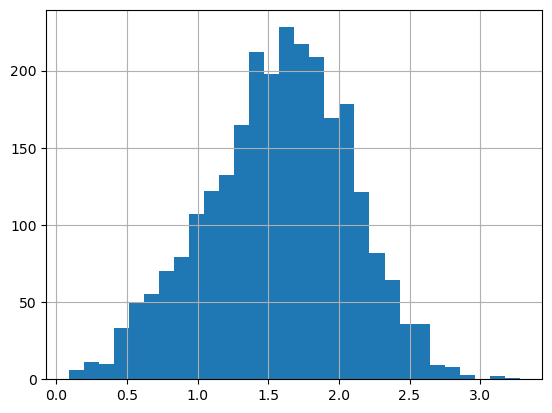

In [84]:
one_sec_dist_df['one_sec_dist'].hist(bins=30);

In [89]:
speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['end_name'].unique()[0]).reset_index().rename(columns={0:'end_name'})['end_name'].value_counts()[0:50]

Harold Landry          77
Chase Young            40
Myles Garrett          37
Shaquil Barrett        36
Jason Pierre-Paul      33
Khalil Mack            33
Brian Burns            31
Yannick Ngakoue        31
Trey Hendrickson       30
Haason Reddick         30
Derek Barnett          30
T.J. Watt              29
Malik Reed             28
Von Miller             27
Leonard Floyd          27
Joey Bosa              26
Alex Highsmith         26
Cameron Jordan         25
Al-Quadin Muhammad     25
Matt Judon             24
Montez Sweat           24
Danielle Hunter        24
Josh Allen             24
Maxx Crosby            23
Rashan Gary            23
Darrell Taylor         23
Everson Griffen        22
Preston Smith          21
Chandler Jones         21
Terrell Lewis          21
Nick Bosa              20
Olasunkanmi Adeniyi    20
Robert Quinn           20
Odafe Oweh             20
Aaron Donald           20
Bryce Huff             19
Dante Fowler           19
Randy Gregory          19
Josh Sweat  